# Opening and cleaning out openephys data

Note: Use L1imag/formation environment.
## Import packages

In [ ]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

#%reset

: 

## Load data
### Load timestamps from continuous recording

Note here the synchronised timestamps are not loaded. Attempt is made next cell but there is a bug because the files are of different lengths. 
What needs to be done is to understand the exact content of these files to then load them properly.

In [10]:

folder = Path('.').absolute()
print(folder)
path_list_ERS = []
Ephys_rec_stamps = {}

for file in folder.glob('**/*continuous/Rhythm_FPGA-112.0/timestamps.npy'):
    path_list_ERS.append(file)

for file_path in folder.glob('**/*continuous/Rhythm_FPGA-112.0/timestamps.npy'):
    recording = file_path.parents[2].stem
    arr = np.load(file_path)
    Ephys_rec_stamps[recording] = arr

## Here the timestamps are stored in a dict which is not necessarily what I want, maybe will need to amend that

    


/Users/ahay/Documents/DATA/L1imaging


In [ ]:
# Not working yet as synchronised timestamps and timestamps for recording 2 are of different size.

TTL_stamp2 = []
for file_path in folder.glob('**/*.npy'):
    subfolder = file_path.parents[1].stem
    if subfolder == 'continuous':
        recording = file_path.parents[2].stem.replace('recording','')
        print(recording)
        file = file_path.stem
        print(recording, file)
        np_arr = np.load(file_path)
        datalen = len(np_arr)
        print(file, datalen)
        if recording == 1: #not in TTL_stamp2:
            TTL_stamp2.append(recording)
            coords = {
                'channels' : np.array(['synchronized_timestamps', 'timestamps']),
                'duration_rec' : np.arange(datalen)
            }
            globals()[f"StampsCont_{recording}"] = xr.DataArray(coords=coords, dims=['channels', 'duration_rec'])
        globals()[f"StampsCont_{recording}"].loc[file,:] = np_arr   


### Load timestamps for miniscope frames and laser (TTL in)


In [3]:

TTL_stamps = []
list_recordings = []
for file_path in folder.glob('**/*.npy'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'TTL_1':
        recording = file_path.parents[3].stem.replace('recording','')
        file = file_path.stem
        np_arr = np.load(file_path)
        datalen = len(np_arr)
        if recording not in TTL_stamps:
            TTL_stamps.append(recording)
            list_recordings.append(file_path.parents[3].stem)
            coords = {
                'channels' : np.array(['full_words', 'timestamps', 'channel_states', 'channels']),
                'duration_rec' : np.arange(datalen)
            }
            globals()[f"Allstamps_{recording}"] = xr.DataArray(coords=coords, dims=['channels', 'duration_rec'])
        globals()[f"Allstamps_{recording}"].loc[file,:] = np_arr   




### Load recordings

In [11]:

folder = Path('.').absolute()
list_raw = []
for file_path in folder.glob('**/*.dat'):
    subfolder = file_path.parents[1].stem
    if subfolder == 'continuous':
        recording = file_path.parents[2].stem.replace('recording','')
        file = file_path.stem
        print(recording)
        globals()[f"DataRec_{recording}"] = np.fromfile(file_path, dtype="int16")
        globals()[f"DataRaw_{recording}"] = globals()[f"DataRec_{recording}"].reshape(-1,32)
        list_raw.append(f"DataRaw_{recording}")

1
2
1
2
1
2
4
3
1
1


### Distribute channels.

EMG = 11, deep PFC = 17, superficial PFC = 18, deep S1 = 24, superficial S1 = 23, deep CA1 = 21, superficial CA1 = 20

WARNING: this has to be adjusted for every mouse. In the future, add a cell at the beginning to enter these parameters

In [5]:
list_rawchan = []

for ele, file in enumerate(list_raw):
    ele2 = ele + 1
    # Distribute
    EMG = globals()[f"DataRaw_{ele2}"][:,10]
    PFC = globals()[f"DataRaw_{ele2}"][:,17] #- globals()[f"DataRaw_{ele2}"][:,17]
    S1 = globals()[f"DataRaw_{ele2}"][:,22] - globals()[f"DataRaw_{ele2}"][:,23] 
    CA1 = globals()[f"DataRaw_{ele2}"][:,20]- globals()[f"DataRaw_{ele2}"][:,19]
    # Stack back
    globals()[f"Good_channels_{ele2}"] = np.stack((EMG, PFC, S1, CA1), axis = 1)#.reshape(-1, 4)
    nmberchann = globals()[f"Good_channels_{ele2}"].shape
    datalen = globals()[f"Good_channels_{ele2}"].size / nmberchann[1]
    print(datalen)
    coords = {
        'brain_areas' : np.array(['EMG', 'PFC', "S1", "CA1"]),
        'duration_rec' : np.arange(0, datalen/25000, 1/25000)
    }
    # Put in xarray
    globals()[f"xrGoodChannels_{ele2}"] = xr.DataArray(coords=coords, dims=['duration_rec', 'brain_areas'])
    globals()[f"xrGoodChannels_{ele2}"].loc[:,:]  = globals()[f"Good_channels_{ele2}"]
    Good_channels = globals()[f"xrGoodChannels_{ele2}"]
    # Save datas
    np.save(f'RawDataChannelExtracted_{ele2}.npy', Good_channels)
    list_rawchan.append(Good_channels)
    # Empty array to free memory 
    globals()[f"DataRaw_{ele2}"] = None


21688064.0
19644672.0


#  Downsample all signals to 1 kz.


In [6]:

#list_rawchan = [xrGoodChannels_1, xrGoodChannels_2]
list_rawchan_filt = []
for ele, file in enumerate(list_rawchan):
    ele2 = ele + 1
    print(ele2)
    sampling_rate = 25000 # Hz
    new_sampling_rate = 1000 # Hz
    nmberchann = file.shape
    datalen = file.size/ nmberchann[1]
    Nmber_points = int(datalen * new_sampling_rate / sampling_rate)
    print(datalen, Nmber_points)
    globals()[f"DS_GoodChannels_{ele2}"] = signal.resample(file, Nmber_points, axis = 0)
    Good_channels_filtered = globals()[f"DS_GoodChannels_{ele2}"]
    list_rawchan_filt.append(Good_channels_filtered)
    np.save(f'RawDataChannelExtractedDS_{ele2}.npy', Good_channels_filtered)
    globals()[f"xrGoodChannels_{ele2}"] = None

list_rawchan = None

# if done and no intention to display for assessment
#%reset

1
21688064.0 867522
2
19644672.0 785786


## End of notebook. 
Data is cleaned up and saved. Data processing for different cortical areas on specific notebooks. Next step is WakeRemoving notebook.

Below is for quick filtering, plotting and visualisation to assess data quality. Filtering for data processing is done again in specific notebooks.

Data quality is assessed on a Sample, whose value has to be attributed on the initial cell.

## Filtering 

SWR: 120 - 200 Hz

In [51]:
Sample = filtered_GoodChannels_1

f_CA1 = Sample[:, 3].copy()

# Paramètres de notre filtre :
f_lowcut = 120.
f_hicut = 200.
fs = new_sampling_rate
nyq = 0.5 * fs
N = 6                 # Ordre du filtre
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
print(Wn)

# Création du filtre :
b, a = scipy.signal.butter(N, Wn, 'band')
filt_SWR_CA1 = scipy.signal.filtfilt(b, a, f_CA1)

times = np.arange(0, f_CA1.size/new_sampling_rate, 1./new_sampling_rate)



[0.24, 0.4]


Spindles: 8 - 16 Hz

In [52]:
f_PFC = Sample[:, 1].copy()
f_S1 = Sample[:, 2].copy()

# Paramètres de notre filtre :
f_lowcut = 10.
f_hicut = 16.
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
N = 4
# Création du filtre :
b, a = scipy.signal.butter(N, Wn, 'band')
filt_Spind_PFC = scipy.signal.filtfilt(b, a, f_PFC)
filt_Spind_S1 = scipy.signal.filtfilt(b, a, f_S1)

# # Calcul de la reponse en fréquence du filtre
# w, h = signal.freqz(b, a)

# # Tracé de la réponse en fréquence du filtre
# fig, ax = plt.subplots(figsize=(8,5)) 

# ax.plot(0.5*fs*w/np.pi, np.abs(h), 'b')

# ax.set_xlabel('frequency [Hz]')
# ax.set_ylabel('Amplitude [dB]')
# ax.grid(which='both', axis='both')

FFT display

Text(0, 0.5, 'PSD [V**2/Hz]')

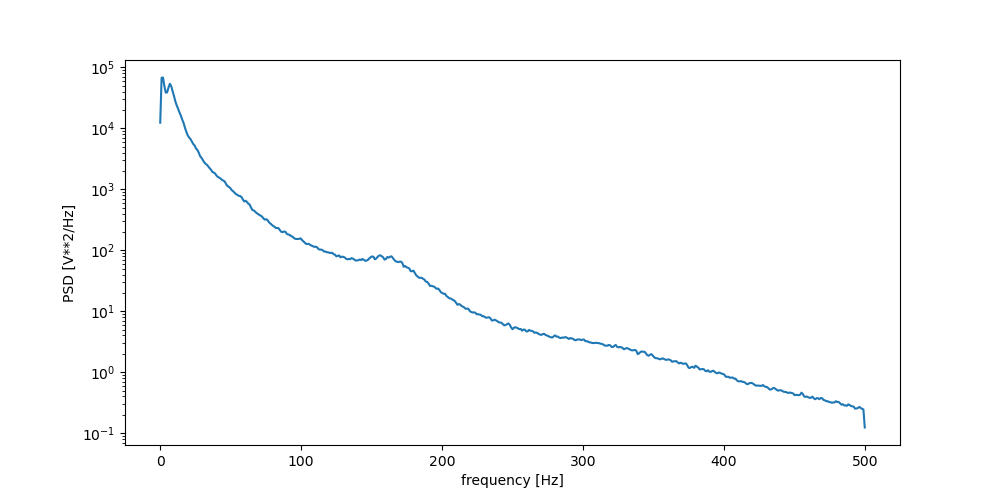

In [54]:
# Calcul du spectre
f, Pxx_den = signal.welch(f_CA1, fs, nperseg=1024)

# Tracé
fig, ax = plt.subplots(figsize=(10,5)) 
ax.semilogy(f, Pxx_den)   #  plot with log scaling on the y axis
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')

In [60]:
plt.close('all')

# Display. 

Can massively be improved: with Matplotlib

In [1]:
times_sliced = times[000:200000]
filt_to_display = filt_SWR_CA1[000:200000]-1000
f_CA1_sliced = f_CA1[0000:200000]/2
combined = np.stack((f_CA1_sliced, filt_to_display), axis = 1)
# Tracé du signal filtré

fig, ax = plt.subplots(1,1, figsize=(15,5), layout='constrained') 
ax.plot(times_sliced, combined, 'r')
ax.set_xlabel('Temps [sec]')
ax.set_ylabel('Amplitude')


NameError: name 'times' is not defined

With ephyviewer. 

In [57]:
# prepare numpy array for ephyviewer

filt_SWR_CA1_sliced= filt_SWR_CA1[000:200000, np.newaxis]
filt_Spind_PFC_sliced= filt_Spind_PFC[000:200000, np.newaxis]
filt_Spind_S1_sliced= filt_Spind_S1[000:200000, np.newaxis]
filt_sliced = Sample[0000:200000,:]
combined2 = filt_sliced[:,0:2].copy()
intf_sliced = filt_sliced[:,2]
intf_sliced = intf_sliced[:, np.newaxis]
combined2 = np.append(combined2, filt_Spind_PFC_sliced, axis=1)
combined2 = np.append(combined2, intf_sliced, axis=1)
combined2 = np.append(combined2, filt_Spind_S1_sliced, axis=1)
intf_sliced = filt_sliced[:,3]
intf_sliced = intf_sliced[:, np.newaxis]
combined2 = np.append(combined2, intf_sliced, axis=1)
combined2 = np.append(combined2, filt_SWR_CA1_sliced, axis = 1)


In [58]:
app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(combined2, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#0055ff'
view1.by_channel_params['ch5', 'color'] = '#ff5500'
view1.by_channel_params['ch6', 'color'] = '#ff5500'

view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00004
view1.by_channel_params['ch3', 'gain'] = 0.0001
view1.by_channel_params['ch4', 'gain'] = 0.0001
view1.by_channel_params['ch5', 'gain'] = 0.00002
view1.by_channel_params['ch6', 'gain'] = 0.00005

view1.by_channel_params['ch0', 'offset'] = 0.3
view1.by_channel_params['ch1', 'offset'] = 0.2
view1.by_channel_params['ch2', 'offset'] = 0.1
view1.by_channel_params['ch3', 'offset'] = 0.
view1.by_channel_params['ch4', 'offset'] = -0.1
view1.by_channel_params['ch5', 'offset'] = -0.2
view1.by_channel_params['ch6', 'offset'] = -0.3

#Run
win.show()
app.exec_()


0